## Data Science Assignment: Car Price Prediction
This notebook applies Xgboost for regression using
Python and pandas.
The following steps are being covered:
1. Data import And Initial Exploration
2. Data Cleaning And Preparation
3. EDA - Data Visualization
4. Feature Engineering
5. Model Training and Evaluation - KNN as baseline & XGBoost as state of the art model
6. Summary And Takeaways

Author:
- Guy Lissak

#### Imports

In [360]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.2

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)


In [361]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

### 1. Data import and initial exploration
In this step we aim to get to know with the data and pre process it, this step includes:
1.   Load and display the data
2.   Plot basic statistics
3.   Display initial features structure





In [362]:
dataset = pd.read_csv('car_web_scraped_dataset.csv')
dataset.head()

,name,year,miles,color,condition,price
0,Kia Forte,2022,"41,406 miles","Gray exterior, Black interior","No accidents reported, 1 Owner","$15,988"
1,Chevrolet Silverado 1500,2021,"15,138 miles","White exterior, Black interior","1 accident reported, 1 Owner","$38,008"
2,Toyota RAV4,2022,"32,879 miles","Silver exterior, Unknown interior","No accidents reported, 1 Owner","$24,988"
3,Honda Civic,2020,"37,190 miles","Blue exterior, Black interior","No accidents reported, 1 Owner","$18,998"
4,Honda Civic,2020,"27,496 miles","Black exterior, Black interior","No accidents reported, 1 Owner","$19,498"


In [363]:
dataset.describe()
# To gain better statistics we will need to transform the features to numeric and run this again

,year
count,2840.000000
mean,2018.833803
std,3.557585
min,2000.000000
25%,2017.000000
50%,2020.000000
75%,2021.000000
max,2024.000000


In [364]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840 entries, 0 to 2839
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       2840 non-null   object
 1   year       2840 non-null   int64 
 2   miles      2840 non-null   object
 3   color      2840 non-null   object
 4   condition  2840 non-null   object
 5   price      2840 non-null   object
dtypes: int64(1), object(5)
memory usage: 133.3+ KB


### 2. Data Cleaning and Preparation
 1. Handling missing values
 2. Handle duplications
 3. Transforming data into a suitable format for analysis.





##### 2.1 Handling missing values
There are no missing values

In [365]:
# For the inital features there are no missing values
dataset.isna().sum()

,0
name,0
year,0
miles,0
color,0
condition,0
price,0


##### 2.2 Handle Duplication
- We see there are 528 duplications, we group by all the columns to analyze the
duplications, we come into conclusion that due to the nature of this dataset which is cars dataset and there are features like miles, years, owners, accident. The duplications are probably not meaningful and are wrongs, hence we remove them.

In [366]:
duplicates = dataset.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 528


In [367]:
# Identify duplicate rows
duplicates = dataset[dataset.duplicated(keep=False)]

# Group by all columns to identify patterns in duplicates and count occurrences
grouped_duplicates = (
    duplicates.groupby(list(dataset.columns))
    .size()
    .reset_index(name="# duplicates")
    .sort_values("# duplicates", ascending=False)
)

# Display the top duplicate groups
print("Most frequently occurring duplicate rows:")
grouped_duplicates.head(10)


Most frequently occurring duplicate rows:


,name,year,miles,color,condition,price,# duplicates
189,Honda Accord,2022,"20,280 miles","White exterior, Unknown interior","No accidents reported, 1 Owner","$26,994",3
163,Ford Mustang,2015,"107,676 miles","Orange exterior, Black interior","No accidents reported, 2 Owners","$14,300",3
313,Mercedes-Benz C-Class,2021,"18,769 miles","Silver exterior, Unknown interior","No accidents reported, 1 Owner","$29,990",3
352,Mercedes-Benz GLE,2020,"80,559 miles","Silver exterior, Black interior","No accidents reported, 1 Owner","$31,888",2
347,Mercedes-Benz GLC,2021,"17,605 miles","Black exterior, Black interior","No accidents reported, 1 Owner","$33,997",2
348,Mercedes-Benz GLC,2022,"12,483 miles","White exterior, Black interior","No accidents reported, 1 Owner","$35,136",2
349,Mercedes-Benz GLC,2022,"56,463 miles","White exterior, Black interior","No accidents reported, 1 Owner","$31,995",2
350,Mercedes-Benz GLE,2016,"69,891 miles","White exterior, Gray interior","1 accident reported, 1 Owner","$22,998",2
351,Mercedes-Benz GLE,2017,"60,253 miles","Unknown exterior, Unknown interior","No accidents reported, 1 Owner","$38,595",2
0,Acura MDX,2013,"91,230 miles","Blue exterior, Gray interior","1 accident reported, 1 Owner","$16,998",2


In [368]:
# Drop Duplicates
df_no_duplicates = dataset.drop_duplicates()
df_no_duplicates.reset_index(drop=True, inplace=True)

print(f"Original dataset had {len(dataset)} rows.")
print(f"Dataset after dropping duplicates has {len(df_no_duplicates)} rows.")
print(f"Number of rows removed: {len(dataset) - len(df_no_duplicates)}")


Original dataset had 2840 rows.
Dataset after dropping duplicates has 2312 rows.
Number of rows removed: 528


##### 2.3 Data Transformations
**data preprocess utils**
1. we clean price and miles columns from $ sign and commas, we split the car name to 2 columns (brand and model), and same for color.
2. we extract the number of accidents and owners from the condition.
3. we notice that there are 'Unknown' values in the inerior and exterior color, we dedicde to keep it an additonal category as xgboost will handle it.

In [369]:
""" Data Preprocess Utils """
def preprocess_data(df: DataFrame) -> DataFrame:

    multi_word_brands = ['Land Rover', 'Rolls Royce', 'Aston Martin', 'Alfa Romeo']

    # Extract the car_brand and car_model
    df['car_brand'] = df['name'].apply(
        lambda x: next((brand for brand in multi_word_brands if brand in x), x.split(' ')[0])
    )
    df['car_model'] = df['name'].apply(
        lambda x: x.replace(df.loc[df['name'] == x, 'car_brand'].values[0], '').strip()
    )

    # Extract numeric values from 'miles' column (remove 'miles' text)
    df['miles'] = df['miles'].str.replace('miles', '').str.replace(',', '').astype(int)

    # Split color into exterior and interior color
    df[['exterior_color', 'interior_color']] = df['color'].str.extract(r'(.*?)\s*exterior,\s*(.*?)\s*interior')

    # Process condition column (extract accident and owner information)
    condition_list = list(map(lambda x: x.split(" "), df["condition"]))
    owners = [i[-2] for i in condition_list]
    accidents = [i[0] for i in condition_list]
    accidents = list(map(lambda x: 0 if (x == "No") else x, accidents))
    df["owner_count"] = owners
    df["owner_count"] = df["owner_count"].astype(int)
    df["accident_count"] = accidents
    df["accident_count"] = df["accident_count"].astype(int)

    # Remove '$' and ',' from price and convert to float
    df['price'] = df['price'].str.replace(r'[$,]', '', regex=True).astype(float)

    df = df.drop(['name', 'color', 'condition'], axis=1)

    return df

In [370]:
df_cleaned = preprocess_data(df_no_duplicates)
df_cleaned

,year,miles,price,car_brand,car_model,exterior_color,interior_color,owner_count,accident_count
0,2022,41406,15988.0,Kia,Forte,Gray,Black,1,0
1,2021,15138,38008.0,Chevrolet,Silverado 1500,White,Black,1,1
2,2022,32879,24988.0,Toyota,RAV4,Silver,Unknown,1,0
3,2020,37190,18998.0,Honda,Civic,Blue,Black,1,0
4,2020,27496,19498.0,Honda,Civic,Black,Black,1,0
...,...,...,...,...,...,...,...,...,...
2307,2013,98601,8995.0,Ford,Escape,Silver,Unknown,3,2
2308,2009,120694,9495.0,Mercedes-Benz,R-Class,Black,Black,3,1
2309,2022,27894,29999.0,Mercedes-Benz,GLC,Gray,Gray,2,0
2310,2021,50220,22992.0,Honda,CR-V,Gray,Unknown,1,0


In [371]:
# We have cleaned and transform the data to meaningful features, we can now display
# basic statistcs of the data
df_cleaned.describe()

,year,miles,price,owner_count,accident_count
count,2312.000000,2312.000000,2312.000000,2312.000000,2312.000000
mean,2018.873702,49896.590398,25841.419983,1.504325,0.281142
std,3.466794,36287.386865,13880.328572,0.852607,0.593947
min,2000.000000,25.000000,4395.000000,0.000000,0.000000
25%,2017.000000,23590.250000,17991.000000,1.000000,0.000000
50%,2020.000000,40703.000000,22999.000000,1.000000,0.000000
75%,2021.000000,69360.250000,30999.250000,2.000000,0.000000
max,2024.000000,307292.000000,252900.000000,8.000000,5.000000


In [372]:
df_cleaned.isna().sum()

,0
year,0
miles,0
price,0
car_brand,0
car_model,0
exterior_color,0
interior_color,0
owner_count,0
accident_count,0


### 3. Data Visualization (EDA)
1. Histogram and density for numerical features and target
2. Box plots of numerical features and target
3. Bar plots for categorical features
4. Corraltion matrix
5. Relations with the target
6. EDA conculsions

In [373]:
""" Plots Utils Module """
def plot_histogram_and_density(df: DataFrame, feature: str, bins:int=20):
    """
    Plot histogram and KDE (density) for a given feature side by side
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    # Histogram plot
    sns.histplot(df[feature], bins=bins, ax=axes[0], color="skyblue", label="Histogram")
    axes[0].set_title(f'{feature} - Histogram', fontsize=14)
    axes[0].set_xlabel(feature, fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].legend(loc="upper right")

    # Density (KDE) plot
    sns.kdeplot(df[feature], ax=axes[1], color="mediumseagreen", fill=True, linewidth=2, label="Density")
    axes[1].set_title(f'{feature} - Density Plot', fontsize=14)
    axes[1].set_xlabel(feature, fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].legend(loc="upper right")

    # Adjust spacing
    plt.tight_layout()
    plt.show()

def plot_boxplots_with_labels(df: DataFrame, features: List[str]):
    """
    Plot boxplots for the provided numerical features
    """
    fig, axs = plt.subplots(1, len(features), figsize=(18, 6), sharey=False)

    for i, feature in enumerate(features):
        # Plot the boxplot
        sns.boxplot(y=df[feature], ax=axs[i], color="coral")
        axs[i].set_title(f"Box Plot of {feature}")
        axs[i].set_xlabel("Feature")
        axs[i].set_ylabel("Value")
        axs[i].legend([feature], loc="upper right")
    plt.tight_layout()
    plt.show()

def plot_categorical_distribution(df: DataFrame, features: List[str], top_n: int | None=None):
    """
    Create bar plots for top N categories of categorical features with counts
    displayed near each bar.
    """
    for feature in features:
        plt.figure(figsize=(10, 6))

        if top_n is not None:
            top_categories = df[feature].value_counts().head(top_n)
        else:
            top_categories = df[feature].value_counts()

        # Plot the bar chart
        ax = sns.barplot(y=top_categories.index, x=top_categories.values, palette="muted")

        # Add counts near each bar
        for i, value in enumerate(top_categories.values):
            ax.text(value + 0.5, i, str(value), va='center', fontsize=10)

        # Add titles and labels
        plt.title(f'{"Top " + str(top_n) if top_n is not None else ""}{feature.capitalize()} Distribution')
        plt.xlabel('Count')
        plt.ylabel(feature.capitalize())
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

def plot_numerical_features_vs_target(features: List[str]):
    """ Create scatter plots of numerical features compared to target """
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    axes = axes.ravel()

    for idx, feature in enumerate(features):
        sns.scatterplot(data=df_cleaned,
                      x=feature,
                      y='price',
                      ax=axes[idx])
        axes[idx].set_title(f'{feature} vs price')

    plt.tight_layout()
    plt.show()


def plot_mean_price_per_category(df: DataFrame, category_column: str, price_column: str ='price'):
    """
    Plots the mean price of each category in the dataset.
    """
    mean_price_per_category = df.groupby(category_column)[price_column].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    bars = plt.bar(mean_price_per_category.index, mean_price_per_category.values, color='salmon', label='Mean Price')
    plt.title(f"Mean Price by {category_column}", fontsize=16)
    plt.xlabel(f"{category_column}", fontsize=12)
    plt.ylabel('Mean Price ($)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




##### 3.1 Histogram and density graphs

Year - Histogram and Density
- The majority of the cars in the dataset are from more recent years (2018 to 2022), with a clear peak around 2020-2022.
This suggests that the dataset contains newer cars, likely reflecting current market trends.
- The histogram shows a left-skewed distribution, the density plot shows this asymmetry clearly
- The model might be more reliable for newer cars given the data distribution

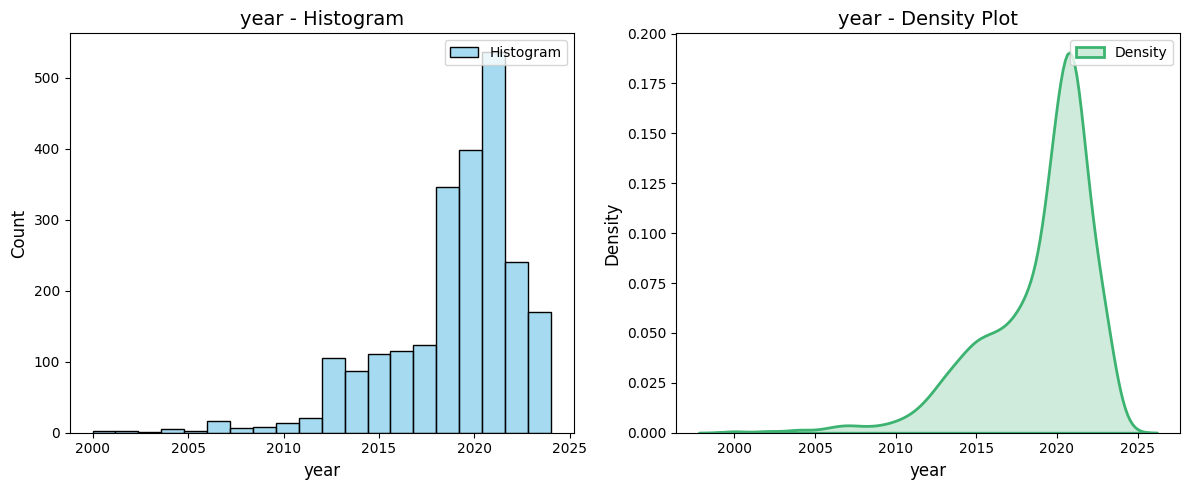

In [374]:
plot_histogram_and_density(df_cleaned, 'year')

Owner count - Histogram and Desnity
- Most cars have 1 previous owner, as seen from the histogram's peak and the density plot's highest spike.
- A significant number of cars have 2 previous owners, with a much smaller number having 3 or more owners.
- Owner count can be a useful predictor for price, as a higher owner count might indicate lower reliability or perceived value, potentially lowering the price.
- Cars with very high owner counts (e.g., 6, 7, or 8) may need to be treated carefully as they could be outliers in the dataset.

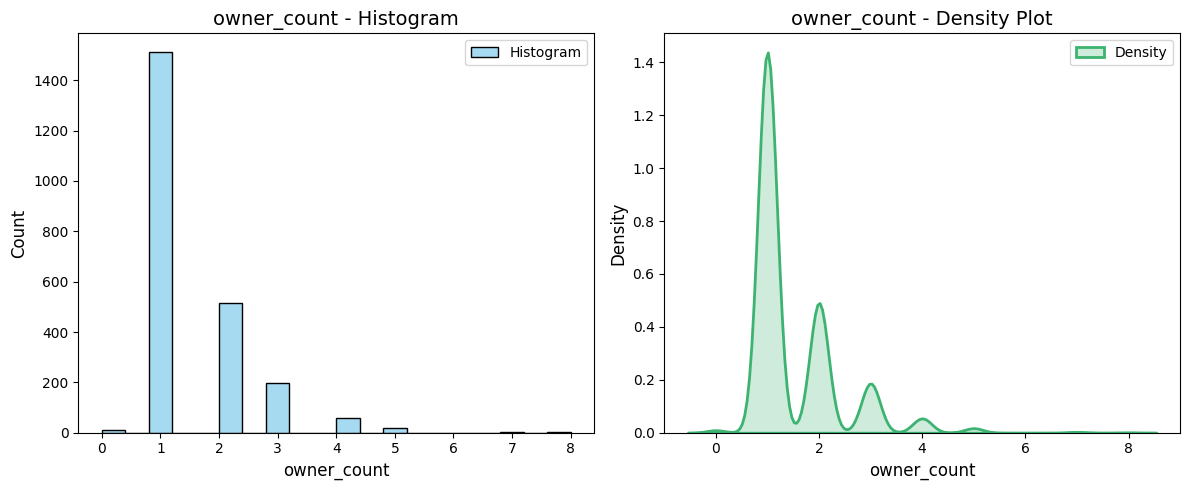

In [375]:
plot_histogram_and_density(df_cleaned, 'owner_count')

Accident count - Histogram and Density
- Extremely skewed towards cars with no accidents (0 count)
- Approximately 2000+ vehicles have no accident history
- 3+ accidents: Very rare (fewer than 50 cars each)

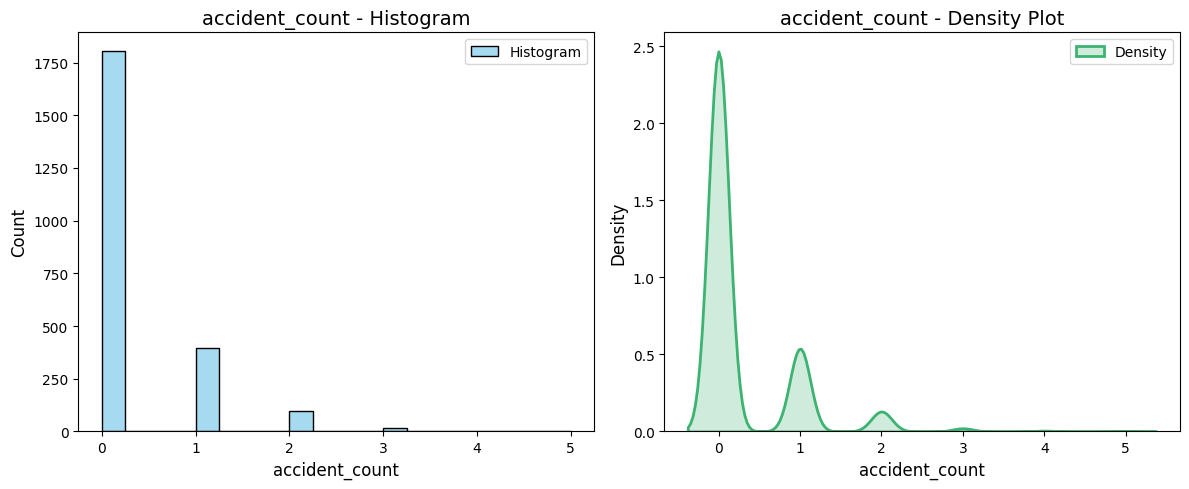

In [376]:
plot_histogram_and_density(df_cleaned, 'accident_count')

Miles - Histogram and Density
- Right-skewed (long tail to the right)
- Highest concentration of vehicles between 0-100,000 miles
- Sharp drop in frequency after 100k
- A small number of cars have extremely high mileage (up to 300,000 miles). These are rare but valid entries.


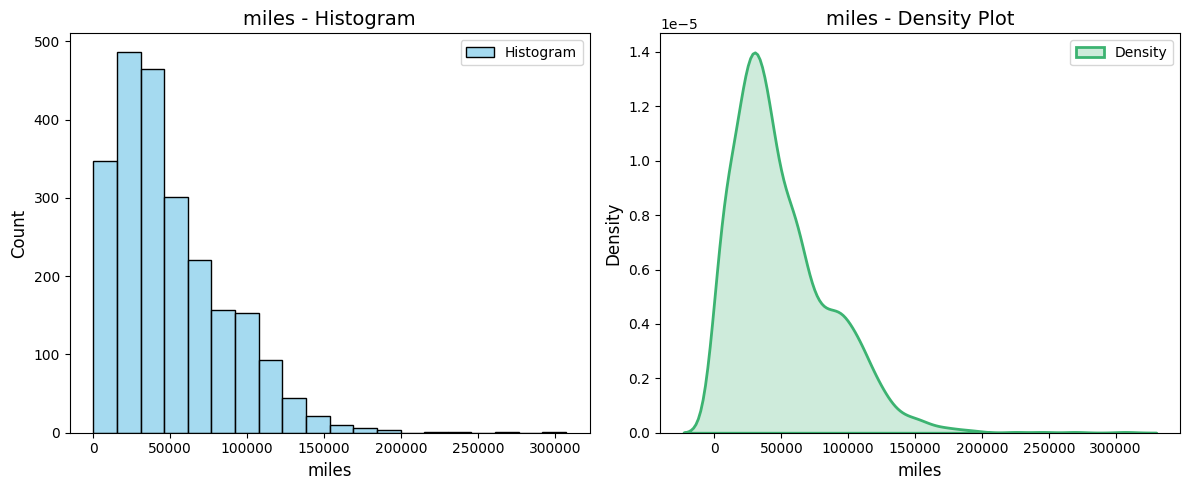

In [377]:
plot_histogram_and_density(df_cleaned, 'miles')

Price - Histogram and Density
- A large proportion of the cars are priced between 20K to $40K. (Right Skew)
- There are fewer cars with higher prices, and the number diminishes as the price increases.
- The density curve confirms the right skew in the data.
- The peak of the curve represents the most frequent price range (mode) which is in the lower price range.
- While XGboost handles skew distribution for features, having extreme skew in the target is more problematic, espcially in small dataset like ours as the model can overfit easily. hence it's reasonable to remove the extreme ones.

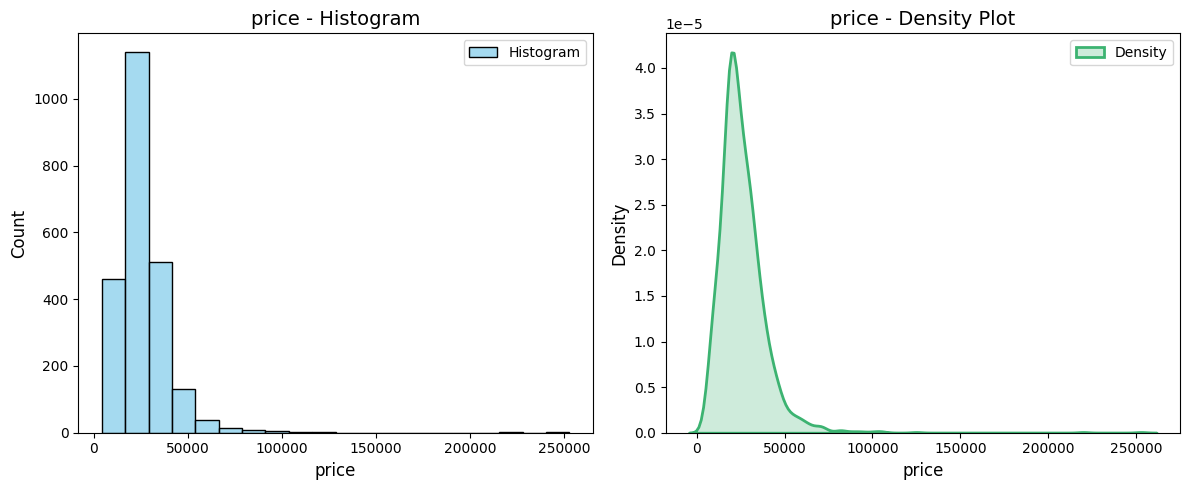

In [378]:
plot_histogram_and_density(df_cleaned, 'price')

** !!! Important note **

While all feature outliers value make sense (for example there are indeed extreme cases where cars get to 300K miles)
we want to make sure the price outlier makes sense by viewing the car brand and models of high prices.

For that we check the most expensive price anaomalies and we see indeed all of them are luxury cars. it's important to look at the data in the eyes to make sure there are no anomalies in the labeling, and understand our anomalies, espcially in the target variable.

In [379]:
most_expensive_cars = df_cleaned.sort_values(by='price',ascending=False).head(10)
most_expensive_cars

,year,miles,price,car_brand,car_model,exterior_color,interior_color,owner_count,accident_count
1586,2018,14272,252900.0,Rolls-Royce,Dawn,White,Beige,2,0
1393,2018,8652,219999.0,McLaren,720S,White,Unknown,3,0
518,2023,8483,124995.0,Audi,RS 6 Avant,Gray,Black,1,0
1684,2020,4080,105888.0,Aston Martin,Vantage,Gray,Black,1,0
685,2023,4813,104784.0,Mercedes-Benz,S-Class,Black,Black,1,0
20,2021,21991,102167.0,Porsche,Cayenne,Silver,Black,1,0
1098,2022,16010,99995.0,Cadillac,Escalade,White,Black,1,0
2195,2022,10504,95295.0,Mercedes-Benz,GLE,Silver,Black,1,0
660,2023,2088,93000.0,Chevrolet,Corvette,Silver,Black,1,0
738,2023,13889,89991.0,Cadillac,Escalade,Gray,Black,1,0


##### 3.2 Box plots

- Year Box Plot:
The median year is around 2020, with most cars concentrated between 2017-2022, showing this is primarily a recent used car dataset. Several outliers below 2010 indicate a small subset of older vehicles in the market.

- Miles Box Plot:
The median mileage is approximately 40,000 miles, with the box (25th to 75th percentile) spanning from 20,000 to 70,000 miles. The numerous outliers above 150,000 miles and long upper whisker demonstrate a significant right skew in the mileage distribution.

- Price Box Plot:
The median price is around USD25,000, with the majority of vehicles priced between USD 15,000 and USD 35,000, indicating a predominantly mid-range market. The multiple high outliers extending beyond $100,000 represent vehicles that are exceptions in this dataset.

- Owner Count Box Plot:
The data shows most vehicles have 1-2 owners, with a strong concentration around a single owner as indicated by the median. The outliers extending up to 8 owners are rare cases and suggest these highly-traded vehicles are uncommon in the market.

- Accident Count Box Plot:
The distribution is heavily concentrated at zero accidents, with the box and whiskers barely visible due to the extreme concentration at zero. All non-zero accident counts appear as outliers, showing that vehicles with accidents are relatively uncommon in this market.

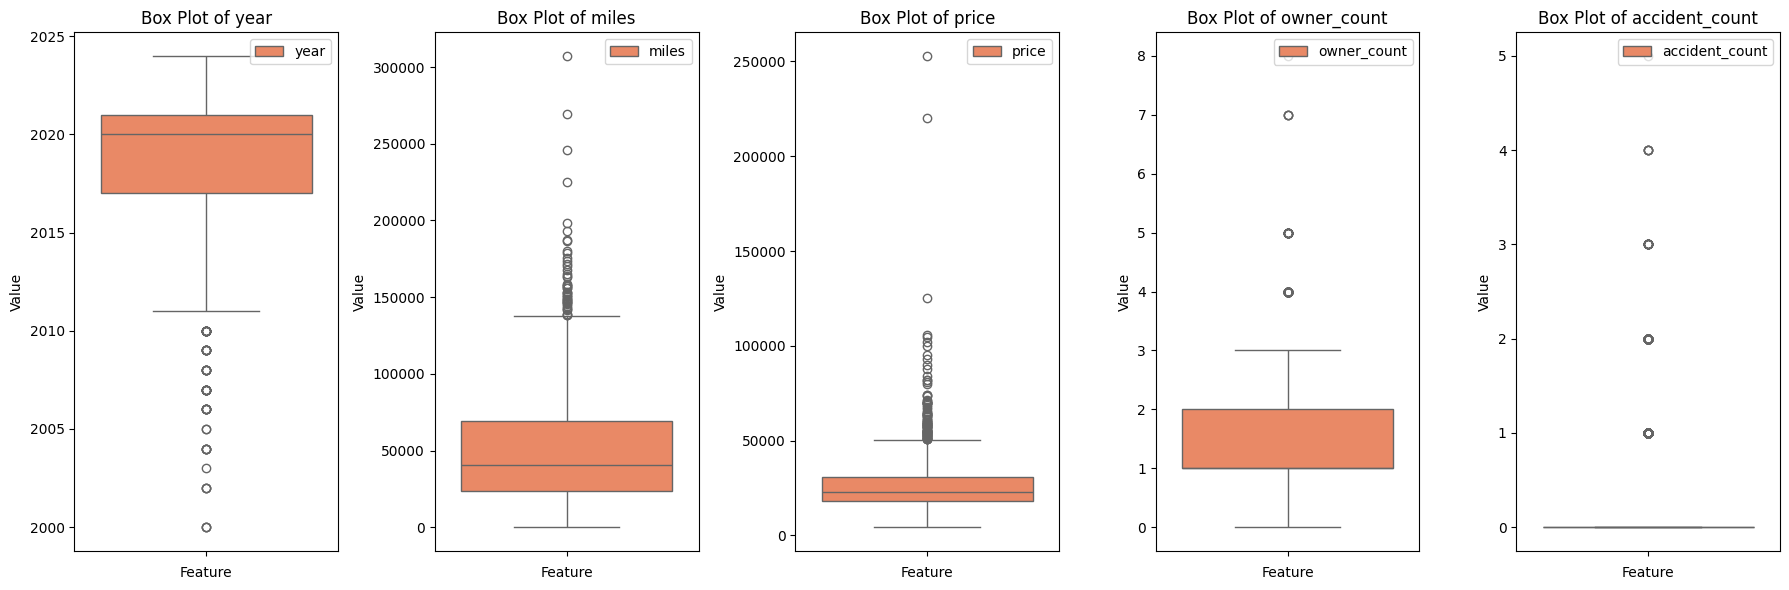

In [380]:
plot_boxplots_with_labels(df_cleaned, ['year', 'miles', 'price', 'owner_count', 'accident_count'])

In [381]:
df_cleaned.shape

(2312, 9)

As we can see, the target variable is heavily right-skewed, which can cause issues, particularly in small datasets. In such cases, the model tends to minimize the large errors from the extreme outliers by assigning extra complexity (e.g., deeper splits or more trees). This additional complexity does not benefit the majority of the data, leading to overfitting and poor generalization.

To address this, it is common to prune a very small percentage of the most extreme outliers. Typical quantile thresholds used for this purpose are between 0.995 and 0.999.
For this case, we chose 0.9975 quantile, removing just the top 0.25% of extreme outliers (only 6 records) from the dataset.

The reason we choose this approach is because the outliers are valid entries, hence we just want to get rid of the extreme ones, Dropping significant amount of the outliers will not reflect the actual performance of the model, so we just prune the edge.

In [382]:

upper = df_cleaned['price'].quantile(0.9975)
df_cleaned[df_cleaned['price'] > upper]


,year,miles,price,car_brand,car_model,exterior_color,interior_color,owner_count,accident_count
20,2021,21991,102167.0,Porsche,Cayenne,Silver,Black,1,0
518,2023,8483,124995.0,Audi,RS 6 Avant,Gray,Black,1,0
685,2023,4813,104784.0,Mercedes-Benz,S-Class,Black,Black,1,0
1393,2018,8652,219999.0,McLaren,720S,White,Unknown,3,0
1586,2018,14272,252900.0,Rolls-Royce,Dawn,White,Beige,2,0
1684,2020,4080,105888.0,Aston Martin,Vantage,Gray,Black,1,0


In [383]:
df_cleaned = df_cleaned[df_cleaned['price']<=upper]
df_cleaned.shape

(2306, 9)

##### 3.3 Bar charts for categorical features

At this phase we want to get familiar with the distriubtion of our categorical features, understand which brand and model dominantes the market, what are the most common and rare colors and get familiar with their taxonmy.

**Distribution by car brand**

The distribution of car brands shows that Toyota, Mercedes-Benz, Ford, and Honda dominate the dataset.
The distribution pattern suggests a market that primarily caters to mainstream and premium segments, with luxury/exotic brands representing a small fraction of the inventory.

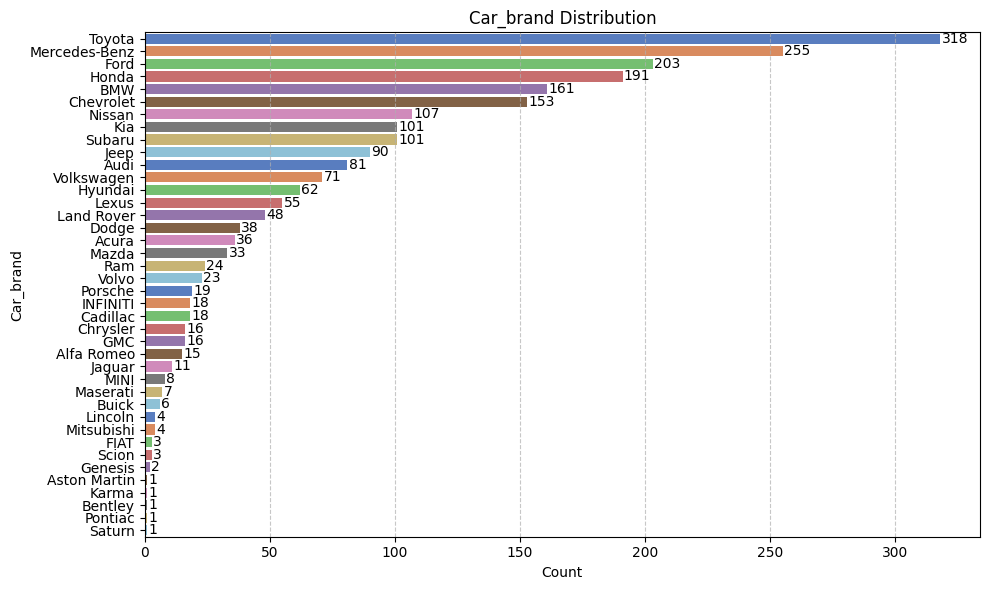

In [384]:
plot_categorical_distribution(df_cleaned, ['car_brand'])

**Distribution by car model Top 20**
Most common car models

The distribution of car models highlights that the Corolla and Civic are the most common, followed closely by the C-Class and Camry. Popular models like the F-150, RAV4, and Outback also appear frequently, indicating their widespread presence in the dataset.

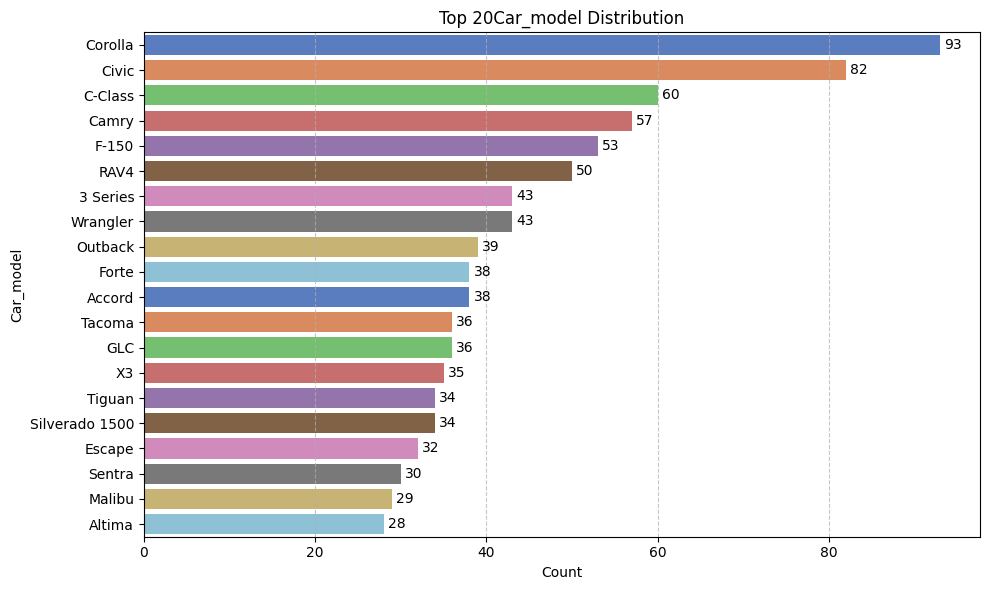

In [385]:
plot_categorical_distribution(df_cleaned, ['car_model'], top_n = 20)

**Distribution by color**

The first graph displays the interior color distribution while black and gray lead the market, and the second graph displays the exterior distribution while white, black and gray dominant.

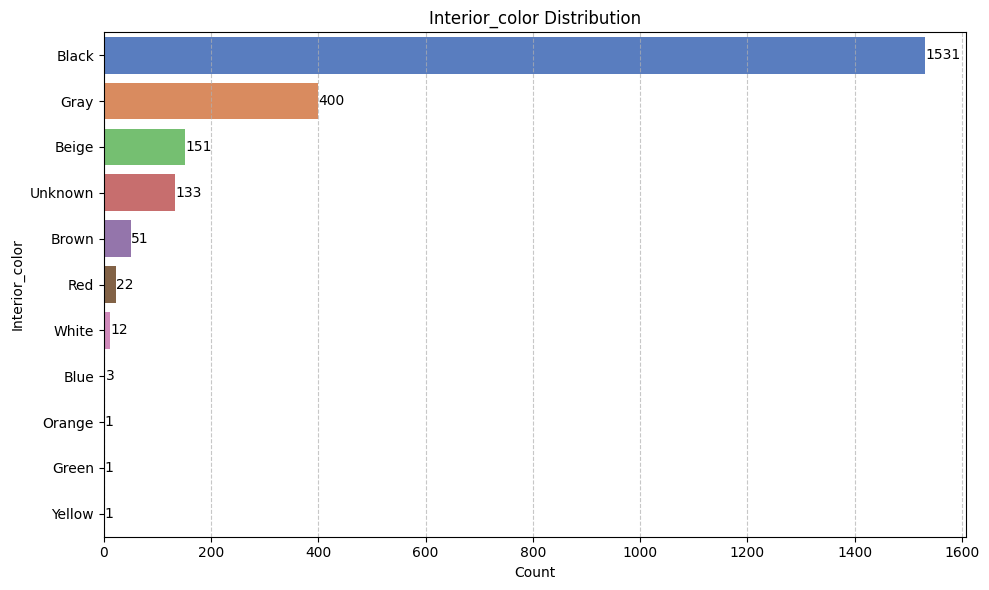

In [386]:
plot_categorical_distribution(df_cleaned, ['interior_color'])

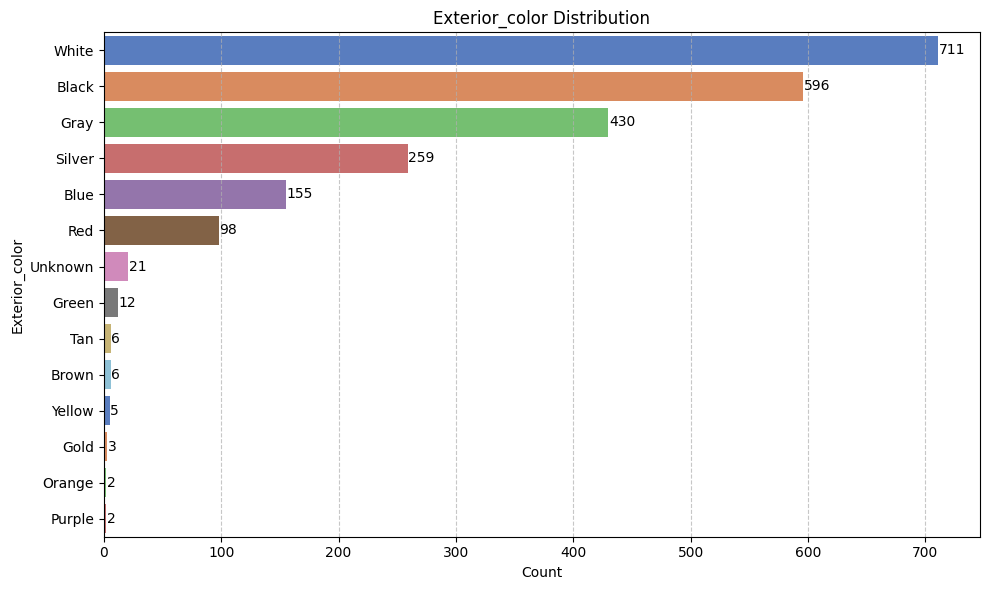

In [387]:
plot_categorical_distribution(df_cleaned, ['exterior_color'])

##### 3.4 Corraltion matrix

- The strongest correlations are between miles and year (-0.71, strong negative) and miles and price (-0.58, moderate negative), indicating that newer cars have lower mileage and higher-mileage cars are generally cheaper.
- Year shows a positive correlation with price (0.51) while having negative correlations with accident_count (-0.26) and owner_count (-0.55), suggesting newer cars are more expensive and tend to have fewer accidents and owners.


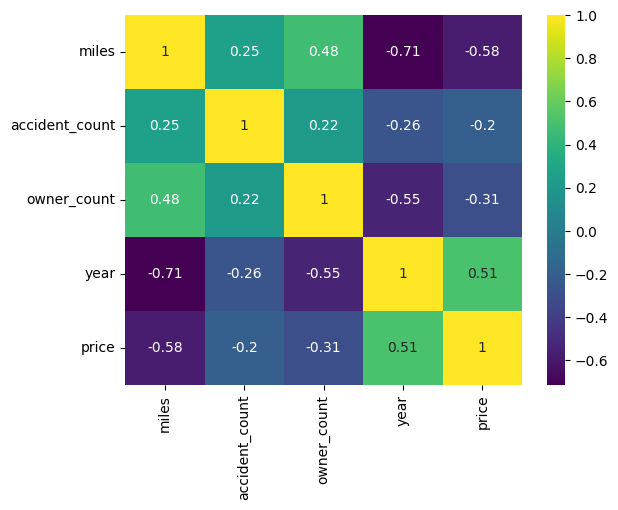

In [388]:
corr_matrix = ['miles', 'accident_count', 'owner_count', 'year', 'price']

df_corr = df_cleaned[corr_matrix].corr()

sns.heatmap(df_corr, annot = True, cmap = 'viridis')
plt.show()

##### 3.5 Relation with target

**3.5.1 Numerical features**

**Year vs Price**: Cars manufactured in recent years have higher prices, showing a positive correlation. This indicates that newer cars generally retain more value than older ones. However, a few outliers exist, where older cars hold high value, possibly due to being vintage or specialty models.

**Miles vs Price**: There is a strong negative correlation between miles driven and price. Cars with higher mileage tend to be cheaper, which is consistent with the idea that more usage leads to wear and tear

**Owner Count vs Price**: Cars with fewer previous owners tend to have higher prices, showing a negative trend, cars with more owners have a wider price range but generally lean towards lower values.

**Accident Count vs Price**: Shows a negative correlation with price. The majority of high-priced vehicles have 0 accidents, with each additional accident associated with lower average prices.

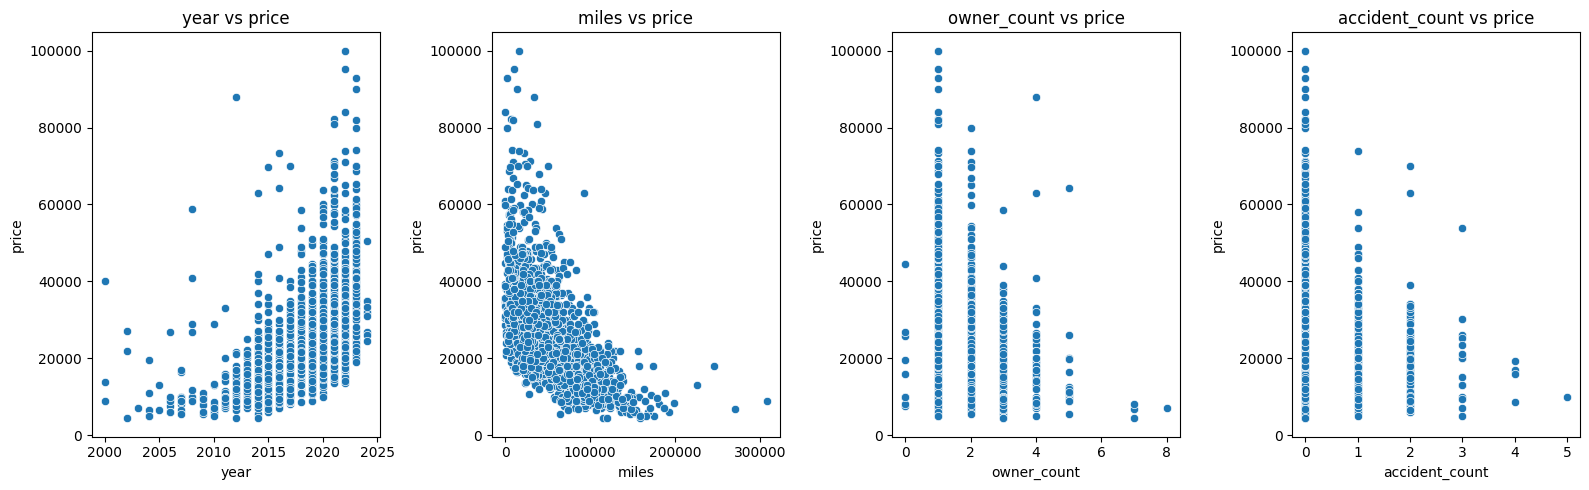

In [389]:
plot_numerical_features_vs_target(["year", "miles", "owner_count", "accident_count"])

**3.5.2** Categorical Features

This bar chart illustrates the mean price of cars by category, with luxury brands such as Rolls-Royce, Porche, and Aston Martin dominating the higher end of the price spectrum. This aligns with our hypothesis that luxury and high-performance brands tend to have significantly higher average prices compared to mainstream brands.
We can assume by the distribution that this is a strong feature against the target.

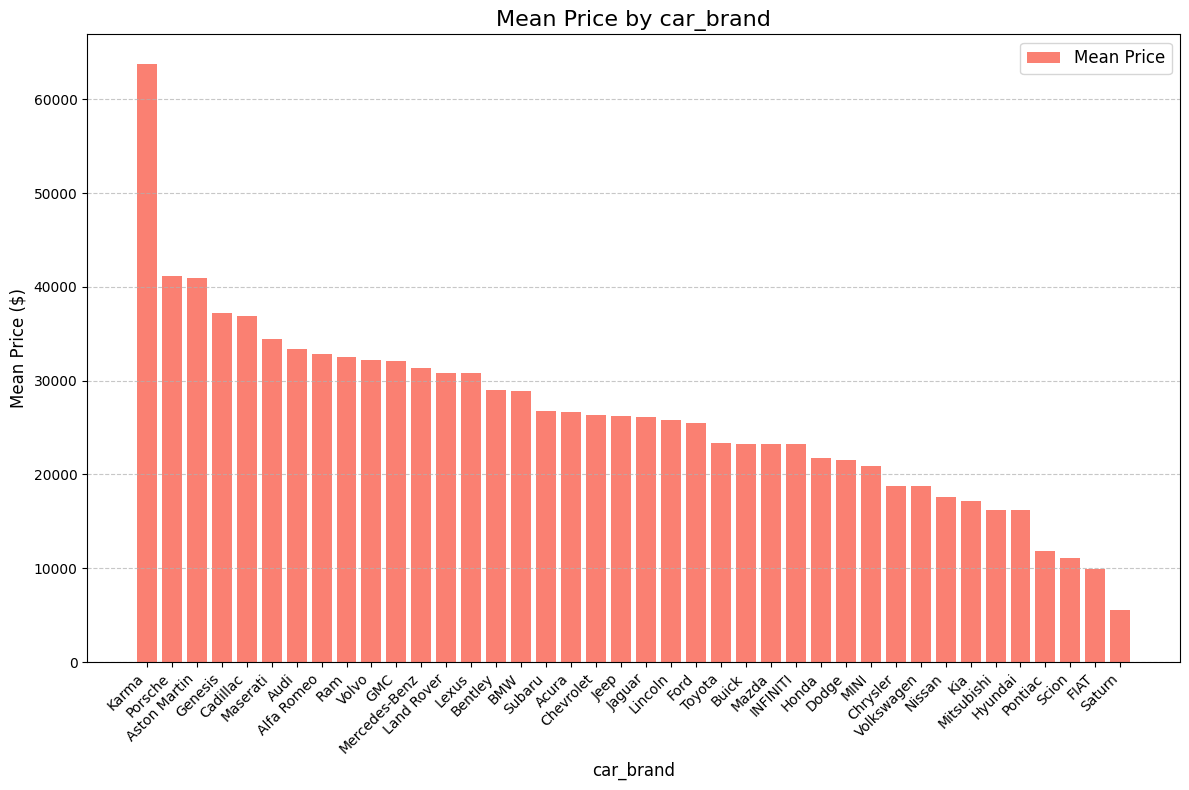

In [390]:
plot_mean_price_per_category(df_cleaned, "car_brand")

This chart indicates that exterior color may serve as a moderately useful feature for predicting car prices. Colors like yellow and green are associated with higher average prices. However, before concluding its predictive strength, this feature should be evaluated alongside other variables in the model, as color alone might not significantly influence price unless it correlates with brand, model, or market trends.

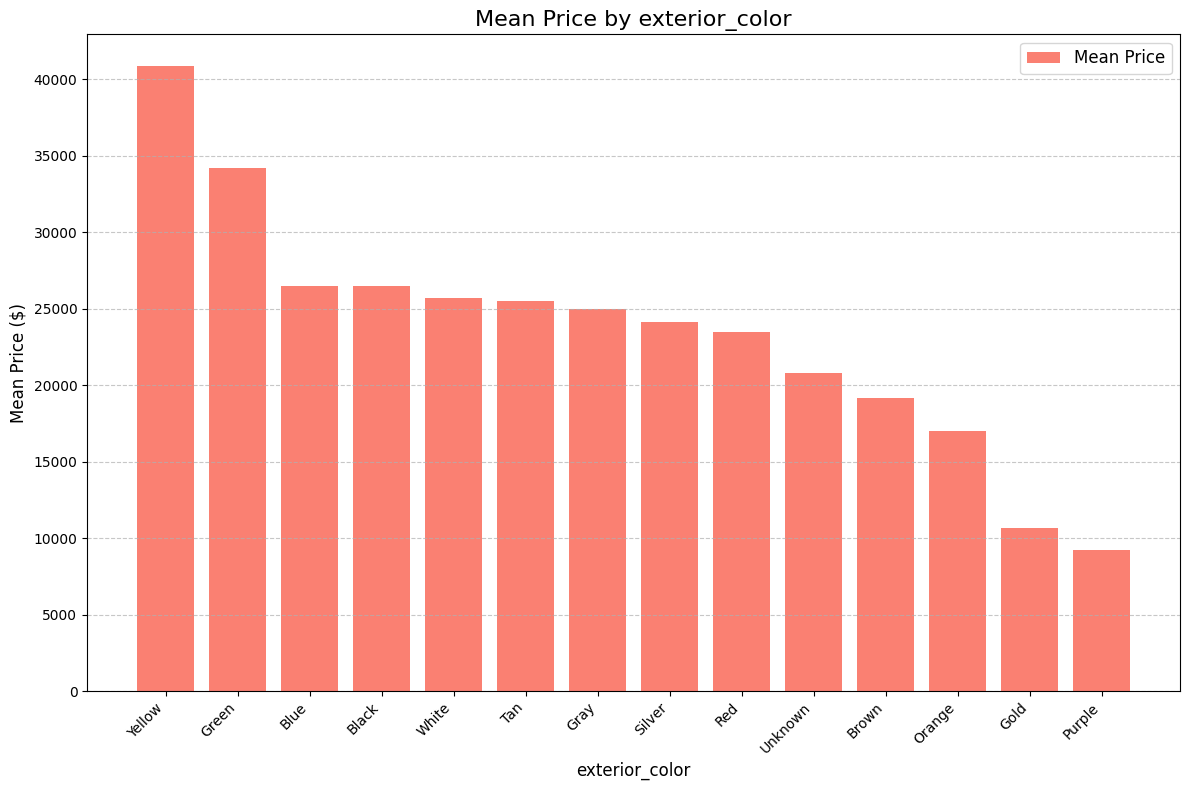

In [391]:
plot_mean_price_per_category(df_cleaned, "exterior_color")

##### 3.6 EDA Conculsions

1. Numerical Features: Mileage and year show the strongest correlations with price, where higher mileage lowers price and newer cars are priced higher, while owner and accident counts have weaker but still have impacts.

2. Categorical Features: Luxury brands like Rolls-Royce and Porsche, strongly related to the target, significantly increase price, while niche colors such as yellow and green, though less common, are moderately associated with higher prices. hence we belive the categorical features (car brand, car model, color) are strong features.

3. During the EDA process, we identified outliers in several features, including price, miles, owner_count, and accident_count. While these outliers represent extreme values, they are logically valid (e.g., luxury cars, high-mileage vehicles, or vehicles with multiple owners). the extreme outliers are less sensitive as features, but in the target they can cause to significant overfit, hence in such dataset's it's common to choose a very high quantile and prune the extreme target outliers above it.

### 4.Feature Engineering
This step involves:
- Features selections and creations
- Split data (train, validation, test).
- Feature scaling.

In [392]:
""" Feature Engineering Utils Module """

def engineer_features(df: DataFrame) -> DataFrame:
    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=['exterior_color', 'interior_color', 'car_brand', 'car_model'], drop_first=True)

    # Calculate car age
    current_year = 2025
    df['car_age'] = current_year - df['year']
    df = df.drop('year', axis=1)

    # Add interaction feature: miles * car_age
    df['miles_car_age_interaction'] = df['miles'] * df['car_age']

    return df

def split_dataset(dataset: DataFrame) -> Tuple[DataFrame,...]:
    """ Split dataset wrapper """

    X = dataset.drop('price', axis=1)
    y = dataset['price']

    # Split out the training data
    X_train, X_rem, y_train, y_rem = train_test_split(
        X, y, train_size=0.8, random_state=42
    )

    # Split the remaining data equally into validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_numerical_data(X_train: DataFrame, X_val: DataFrame, X_test: DataFrame) -> Tuple[np.ndarray,...]:
   numeric_cols = ['miles', 'car_age', 'owner_count', 'miles_car_age_interaction', 'accident_count']

   # Create copy to avoid modifying original
   X_train_scaled = X_train.copy()
   X_val_scaled = X_val.copy()
   X_test_scaled = X_test.copy()

   # Scale only numeric columns in place
   scaler = StandardScaler()
   X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
   X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
   X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

   return X_train_scaled.to_numpy(), X_val_scaled.to_numpy(), X_test_scaled.to_numpy()

In the next part we apply the feature engineering, split and scale parts.
we have decided to keep the outliers but the very top extreme ones as they logically make sense and removing them might improve the accuracy but we want our model to learn to handle them as well as they are not wrong value outliers.

In [393]:
features_df = engineer_features(df_cleaned)
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(features_df)
X_train_scaled, X_val_scaled, X_test_scaled = scale_numerical_data(X_train, X_val, X_test)
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((1844, 371), (231, 371), (231, 371))

### 5. Model Training and Evaluation
This part includes 2 experiments, each experiment includes training a model, evaluate it and displaying the test results.
1. baseline model with KNN
2. XGBoost as State Of The Art Model
  -  Manual hyper params tuning with xgboost
  - Cross Validation and finding best hyper params with CVRandomSearch

For each experiment we are going to evalute the following metrics as the model performances:

1. **Mean Squared Error (MSE)**:
   $
   \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
   $

   MSE measures the average squared difference between actual and predicted values. It gives more weight to larger errors due to the squaring term, making it sensitive to outliers. Lower MSE indicates better model performance.

2. **Root Mean Squared Error (RMSE)**:
   $
   \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
   $

   RMSE is the square root of the mean squared error (MSE) and provides an error measure in the same units as the target variable (y).
   
3. **R² Score**:
   $
   R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
   $

   R² measures the proportion of the variance in the target variable that is explained by the model. Values range from 0 to 1, where 1 indicates perfect predictions and 0 means the model explains no variance. Negative values indicate worse performance than simply predicting the mean.

In [394]:
""" Model wrappers utils """

class KNNRegressorWrapper:
    """ Wrapper for KNN Classifier """
    def __init__(self, n_neighbors=10):
        self.clf = KNeighborsRegressor(n_neighbors=n_neighbors)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    @staticmethod
    def evaluate_model(y_true, y_pred):
        """
        Evaluates the model performance and prints MSE, RMSE, and R2 metrics.
        """
        mse_metric = mean_squared_error(y_true, y_pred)
        rmse_metric = np.sqrt(mse_metric)
        r2_metric = r2_score(y_true, y_pred)

        return {
            "MSE": mse_metric,
            "RMSE": rmse_metric,
            "R2": r2_metric
        }


class XGBRegressorWrapper:
    def __init__(self, n_estimators=1000, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0,
              reg_alpha=0, reg_lambda=0.5, colsample_bytree=0.8,subsample=0.8, early_stopping_rounds=10):

        self.model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42,
        min_child_weight=min_child_weight,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        min_split_loss=min_split_loss,
        eval_metric="rmse",
        early_stopping_rounds=early_stopping_rounds
    )


    def fit(self, X_train_scaled, y_train, X_val_scaled, y_val):
        eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
        self.model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

    def predict(self, X):
        return self.model.predict(X)

    def get_model_score(self, X, y):
        return self.model.score(X, y)

    def get_params(self):
        return self.model.get_params()

    @staticmethod
    def evaluate_metrics(y, y_pred):
        mse_metric = mean_squared_error(y, y_pred)
        rmse_metric = np.sqrt(mse_metric)
        r2_metric = r2_score(y, y_pred)

        return {
            "MSE": mse_metric,
            "RMSE": rmse_metric,
            "R2": r2_metric
        }

    def plot_loss_curve(self):
        """
        Plot training and validation loss (RMSE) curves.
        """
        eval_results = self.model.evals_result()
        plt.figure(figsize=(10, 6))
        epochs = range(len(eval_results["validation_0"]["rmse"]))
        plt.plot(epochs, eval_results["validation_0"]["rmse"], label="Train RMSE")
        if "validation_1" in eval_results:
            plt.plot(epochs, eval_results["validation_1"]["rmse"], label="Validation RMSE")
        plt.title("Training and Validation Loss (RMSE)")
        plt.xlabel("Boosting Rounds")
        plt.ylabel("RMSE")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.show()

    def plot_aggregated_feature_importance(self, feature_names):
        """
        Plot feature importance, aggregating importance for one-hot encoded groups.
        """
        if not hasattr(self.model, 'feature_importances_'):
            raise ValueError("Model is not trained yet. Train the model before plotting feature importance.")

        feature_importances = pd.Series(self.model.feature_importances_, index=feature_names)

        # Define groups for one-hot encoded features
        one_hot_groups = {
            'car_brand': [col for col in feature_names if col.startswith('car_brand_')],
            'car_model': [col for col in feature_names if col.startswith('car_model_')],
            'exterior_color': [col for col in feature_names if col.startswith('exterior_color_')],
            'interior_color': [col for col in feature_names if col.startswith('interior_color_')],
        }

        # Aggregate feature importance for one-hot encoded groups
        aggregated_importance = {}
        for group_name, group_features in one_hot_groups.items():
            aggregated_importance[group_name] = feature_importances[group_features].sum()

        # Include non-categorical features
        for feature in feature_names:
            if not any(feature.startswith(prefix) for prefix in one_hot_groups.keys()):
                aggregated_importance[feature] = feature_importances[feature]

        # Create a DataFrame for plotting
        aggregated_df = pd.DataFrame(list(aggregated_importance.items()), columns=['Feature', 'Importance'])
        aggregated_df = aggregated_df.sort_values('Importance', ascending=False)

        # Plot aggregated feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(aggregated_df['Feature'], aggregated_df['Importance'], color="skyblue")
        plt.title("Feature Importance")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.gca().invert_yaxis()
        plt.grid(axis="x", linestyle="--", alpha=0.7)
        plt.show()


def plot_predicted_vs_actual(y_pred, y_test, sample_num=None, color='red', model_name = 'XGBoost'):
    """
    Plot the predicted vs actual prices for the test set.
    Optionally limit the number of points to `sample_num`.
    """

    # Limit to a sample size if specified
    if sample_num:
        y_pred = y_pred[:sample_num]
        y_test = y_test[:sample_num]

    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_pred, y=y_test, color=color, marker='D')

    # Add titles and labels
    plt.title(f"{model_name} Regression Model: Predicted vs Actual Prices")
    plt.xlabel('Predicted Price of the used cars ($)')
    plt.ylabel('Actual Price of the used cars ($)')
    plt.grid(True)

    # Show the plot
    plt.show()


##### 5.1 KNN baseline

In [395]:
# Create KNN instance
knn_model = KNNRegressorWrapper()

# Train the KNN model
knn_model.fit(X_train_scaled, y_train)

# Predict on training and validation sets
y_train_pred = knn_model.predict(X_train_scaled)
y_val_pred = knn_model.predict(X_val_scaled)
# Evalute the model on validation set
train_metrics = KNNRegressorWrapper.evaluate_model(y_train, y_train_pred)
validation_metrics = KNNRegressorWrapper.evaluate_model(y_val, y_val_pred)

# Print metrics
print("\nTraining Metrics:")
print(f"MSE: {train_metrics['MSE']:.2f}")
print(f"RMSE: {train_metrics['RMSE']:.2f}")
print(f"R2 Score: {train_metrics['R2']:.4f}")

print("\nValidation Metrics:")
print(f"MSE: {validation_metrics['MSE']:.2f}")
print(f"RMSE: {validation_metrics['RMSE']:.2f}")
print(f"R2 Score: {validation_metrics['R2']:.4f}")




Training Metrics:
MSE: 49348282.41
RMSE: 7024.83
R2 Score: 0.6685

Validation Metrics:
MSE: 45773536.96
RMSE: 6765.61
R2 Score: 0.5610


In [396]:
# Display model performance - test metrics
y_test_pred = knn_model.predict(X_test_scaled)
test_metrics = KNNRegressorWrapper.evaluate_model(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"MSE: {test_metrics['MSE']:.2f}")
print(f"RMSE: {test_metrics['RMSE']:.2f}")
print(f"R2 Score: {test_metrics['R2']:.4f}")


Test Metrics:
MSE: 44857027.58
RMSE: 6697.54
R2 Score: 0.6385


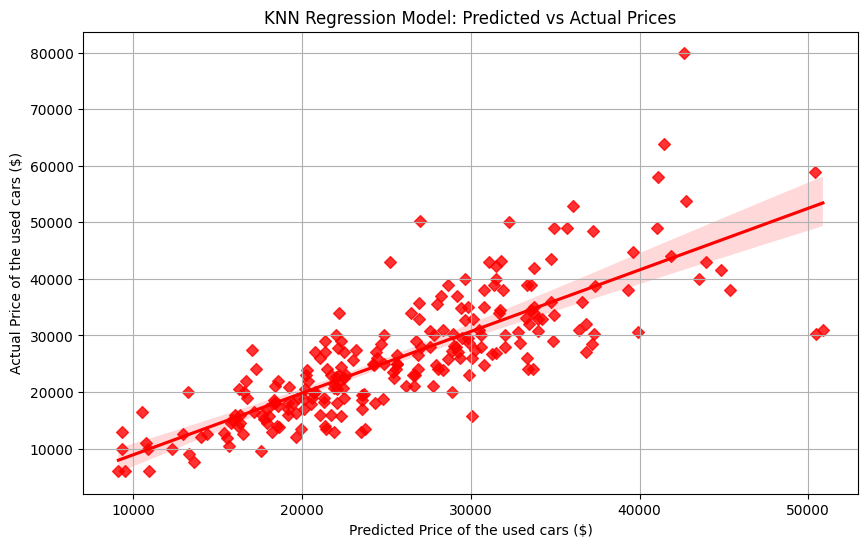

In [397]:
plot_predicted_vs_actual(y_test_pred, y_test, model_name="KNN")

##### 5.1 KNN baseline - summary

- Training and Validation Insights: The KNN model demonstrates a low R² score for both training and validation datasets, indicating that the model struggles to capture the underlying patterns in the data and does not generalize well.

- Test Metrics Interpretation: The test metrics further highlight the model's limitations, with an RMSE of approximately 6,700. This translates to an average error of \$6.7K Dollars in predicting car prices.

- Visual Evidence: The scatterplot highlights the model's limitations, with significant deviations from the diagonal line, particularly for higher prices. This reinforces the need for more advanced models to improve accuracy and generalization.

##### 5.2 xgboost manual tuning and Cross Validation search

The goal of this step is to manually adjust the model's hyperparameters and validate the effectiveness of the feature engineering. We aim to ensure that the model's loss graph, corresponding to boosting rounds, decreases and converges, without showing signs of extreme overfitting or underfitting.

IT'S IMPORTANT TO MENTION THAT WE WILL FOCUS ON REDUCING THE OVERFIT, HAVING HIGH ACCURACY FOR VALIDATION SET WITH OVERFIT IS NOT GOOD!!! IT'S BETTER TO HAVE LOWER ACCURACY BUT NO OVERFIT!

In [398]:
# Instantiate xgboost model with out custom wrapper
xgb_model = XGBRegressorWrapper(n_estimators=1200, learning_rate=0.12, max_depth=4,
              reg_alpha=0, reg_lambda=4, colsample_bytree=0.8,subsample=0.8, min_child_weight=3, early_stopping_rounds=10)


# Fit the model can print the r2 score of both train and validation
xgb_model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
print("\n ------------------------ \n")
train_score = xgb_model.get_model_score(X_train_scaled, y_train)
print(f" Train Model score: {train_score}")
val_score = xgb_model.get_model_score(X_val_scaled, y_val)
print(f" Validation Model score: {val_score}")

# Evalute the model on validation set
y_train_pred = xgb_model.predict(X_train_scaled)
y_val_pred = xgb_model.predict(X_val_scaled)

train_metrics = XGBRegressorWrapper.evaluate_metrics(y_train, y_train_pred)
val_metrics = XGBRegressorWrapper.evaluate_metrics(y_val, y_val_pred)
print("------------------------ \n")
print("Train Metrics:")
print(f"MSE: {train_metrics['MSE']:.2f}")
print(f"RMSE: {train_metrics['RMSE']:.2f}")
print(f"R2 Score: {train_metrics['R2']:.4f}")
print("------------------------ \n")
print("validation Metrics:")
print(f"MSE: {val_metrics['MSE']:.2f}")
print(f"RMSE: {val_metrics['RMSE']:.2f}")
print(f"R2 Score: {val_metrics['R2']:.4f}")


 ------------------------ 

 Train Model score: 0.8227020749404057
 Validation Model score: 0.6940172311862911
------------------------ 

Train Metrics:
MSE: 26396392.41
RMSE: 5137.74
R2 Score: 0.8227
------------------------ 

validation Metrics:
MSE: 31906685.25
RMSE: 5648.60
R2 Score: 0.6940


We were able to find a very good gap between the training RMSE to validation RMSE! We use state of the art techniques like min_child_weights and lambda to prevent complexity and enhance regularization, as well as early_stoping to prevent over fitting.

The below training and validation loss graph illustrates that both training and validation RMSE decrease steadily as boosting rounds progress, indicating consistent model improvement.

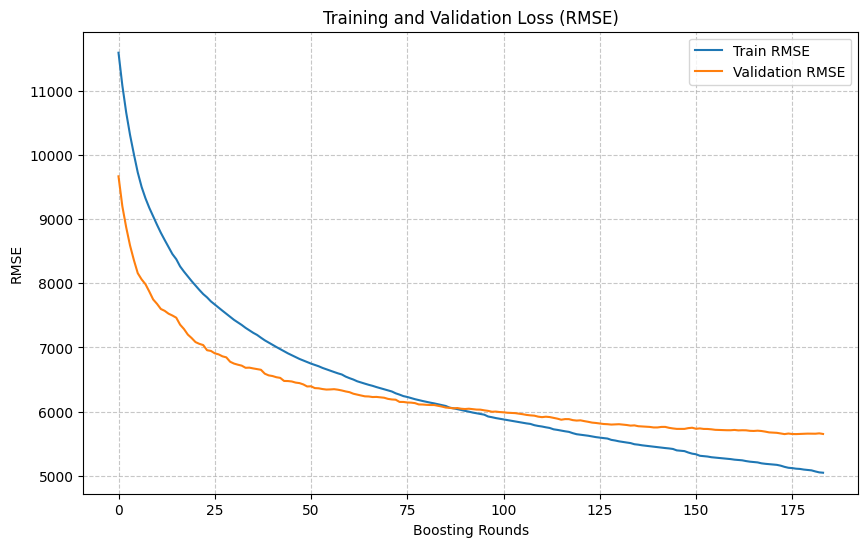

In [399]:
xgb_model.plot_loss_curve()

The below Feature Importance graph shows that car_model and car_brand are the most influential features in predicting car prices, with categorical features dominating the importance. miles and it's combination are the most strong numerical feature.

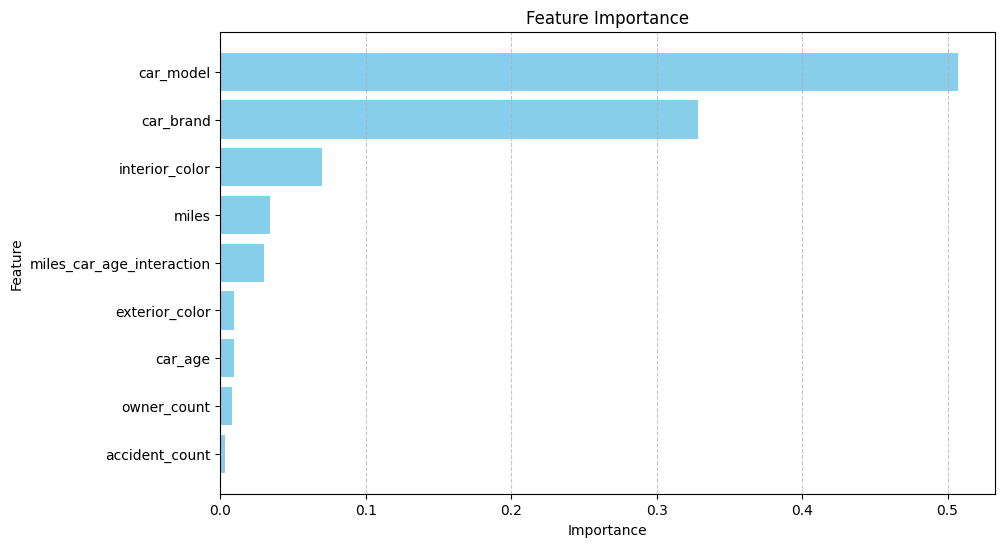

In [400]:
xgb_model.plot_aggregated_feature_importance(X_train.columns.tolist())

**Test results**

In [401]:
test_score = xgb_model.get_model_score(X_test_scaled, y_test)
print(f" Test Model score: {test_score}")

y_test_pred = xgb_model.predict(X_test_scaled)

test_metrics = XGBRegressorWrapper.evaluate_metrics(y_test, y_test_pred)
print("------------------------ \n")
print("Test Metrics:")
print(f"MSE: {test_metrics['MSE']:.2f}")
print(f"RMSE: {test_metrics['RMSE']:.2f}")
print(f"R2 Score: {test_metrics['R2']:.4f}")

 Test Model score: 0.7150950914857834
------------------------ 

Test Metrics:
MSE: 35357249.33
RMSE: 5946.20
R2 Score: 0.7151


The test graph comparing predicted vs. actual prices shows a positive correlation (not the best but positive), with most points closely following the diagonal line, indicating accurate predictions. However, some deviations are visible, particularly at higher price ranges, suggesting the model struggles slightly with extremely high-value vehicles.

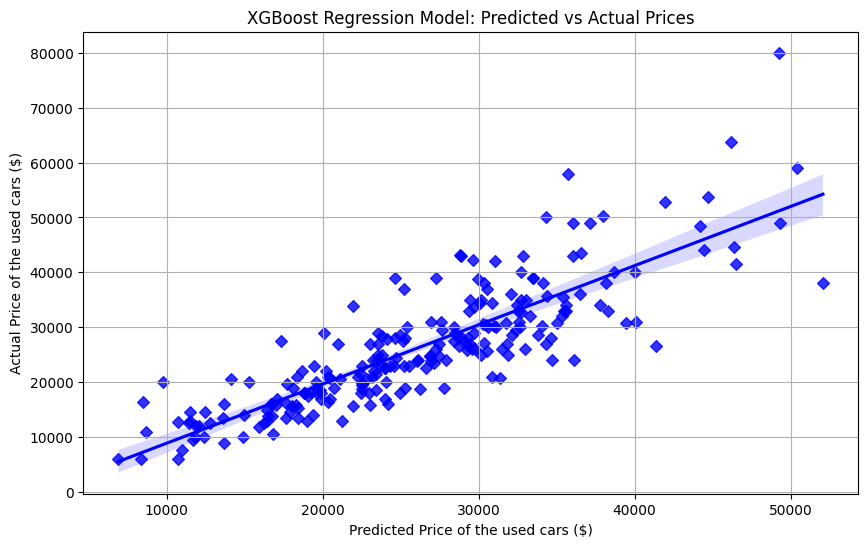

In [402]:
plot_predicted_vs_actual(y_test_pred, y_test, color='blue', model_name="XGBoost")

##### XGBoost Manual Tuning Summary

The XGBoost model demonstrates good predictive performance, as indicated by higher R² scores than the KNN baseline for training (\~0.82), validation (\~0.7), and test (~0.71) sets. The RMSE values, which represent the prediction error in dollars, are 5137.74 for training, 5648.60 for validation, and 5946.20 for testing, showing acceptable generalization with a slight increase in error for unseen data. The learning curve shows effective convergence with minimal overfitting, suggesting that the model is well-tuned.

##### XGBoost cross validation

Now that we know our model works well and able to learn the underlying patterns we will run a random search cross validation with higher number of itteration to find the best hyper paramters and improve the accuracy.
It's important to use a pipeline here to scale each validation fold seperatley to prevent data leakage.

!!! Due to the following bug in randomSearchCv and gridSearchCV with tags for xgboost, we need to downgrade sklearn to test the cross validation params.
https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

In [403]:
# Cross validation already splits each fold to train, validation hence we don't
# need to split to train, val, test and train, test is enough.

X = features_df.drop('price', axis=1)
y = features_df['price']
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [404]:
numeric_cols = ['miles', 'car_age', 'owner_count', 'accident_count', 'owner_count']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing step
    ('xgb', XGBRegressor(random_state=42))  # XGBoost model
])

# Define hyperparameter search space
param_distributions = {
    'xgb__max_depth': [4, 5, 6],
    'xgb__learning_rate': [0.12, 0.16, 0.2, 0.22],
    'xgb__n_estimators': [175, 200, 225],
    'xgb__subsample': [0.6, 0.8, 1],
    'xgb__colsample_bytree': [0.6, 0.8, 1],
    'xgb__reg_lambda': [4, 6],
    'xgb__min_child_weight': [3, 5]
}

# RandomizedSearchCV with pipeline
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=5,
    n_jobs=-1,
    random_state=42
)

# Fit on raw data
random_search.fit(X_cv_train, y_cv_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['miles',
                                                                                'car_age',
                                                                                'owner_count',
                                                                                'accident_count',
                                                                                'owner_count'])])),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           devi...
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.6, 0.8, 1],
                                        'xgb__learning_rate': [0.12, 0.16, 0.2,
                                                               0.22],
                                        'xgb__max_depth': [4, 5, 6],
                                        'xgb__min_child_weight': [3, 5],
                                        'xgb__n_estimators': [175, 200, 225],
                                        'xgb__reg_lambda': [4, 6],
                                        'xgb__subsample': [0.6, 0.8, 1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=5)

In [405]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'xgb__subsample': 1, 'xgb__reg_lambda': 6, 'xgb__n_estimators': 225, 'xgb__min_child_weight': 3, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.22, 'xgb__colsample_bytree': 0.8}


In [406]:
# Evalute test metrics, this is a static function hence we can use it with the
# best result pipeline model
y_cv_test_pred = random_search.best_estimator_.predict(X_cv_test)
test_metrics = XGBRegressorWrapper.evaluate_metrics(y_cv_test, y_cv_test_pred)
print("------------------------ \n")
print("Test Metrics:")
print(f"MSE: {test_metrics['MSE']:.2f}")
print(f"RMSE: {test_metrics['RMSE']:.2f}")
print(f"R2 Score: {test_metrics['R2']:.4f}")

------------------------ 

Test Metrics:
MSE: 31053826.21
RMSE: 5572.60
R2 Score: 0.7330


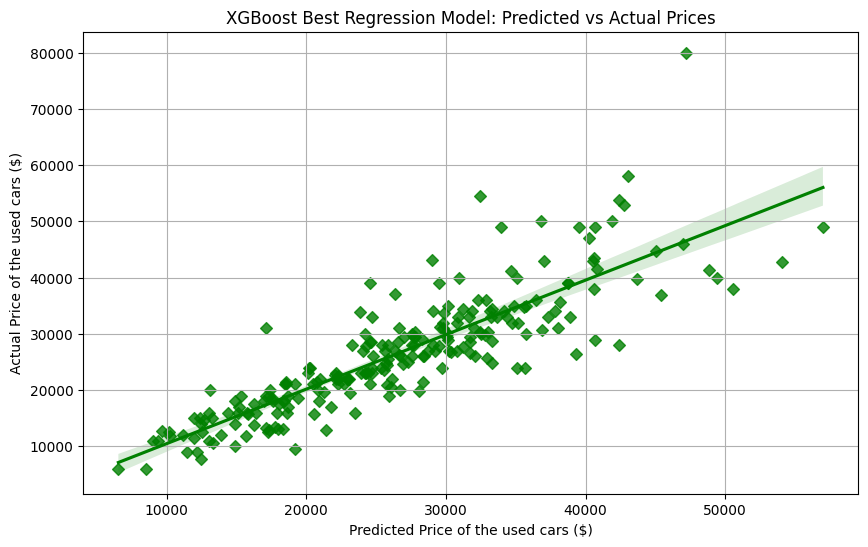

In [407]:
plot_predicted_vs_actual(y_cv_test_pred, y_cv_test, color='green', model_name="XGBoost Best")

The cross-validation test results show good performance with an R² score of 0.7330, indicating the model explains a significant portion of the variability in the actual car prices. The RMSE (5572.60) reflects pretty low prediction errors relative to the price range.

the green graph (cross-validation test) shows a tighter alignment along the regression line compared to the blue graph (manual non cross validation test), indicating slightly improved prediction accuracy.

To optimize the performance, we used RandomSearchCV with a high number of iterations, and the values of parameters like lambda, min_child_weight and n_estimators were kept within pre-defined ranges that we manually checked beforehand to ensure the model would not significantly overfit, as lambda acts as a regularization parameter by penalizing complex tree structures and preventing the model from becoming too specialized to the training data.

### 6. Research Summary And Takeaways

### Summary and Takeaways:

1. **Exploratory Data Analysis (EDA):**  
   - EDA highlighted key relationships, such as the strong negative correlation between mileage and price (-0.58) and a positive correlation between year and price (0.51). Categorical features like car brand and car model proved to be strong predictors, with luxury brands (e.g., Rolls-Royce) and high-demand models significantly increasing car prices.
   - Outliers were observed in numerical features like price, mileage, and owner count, but these were seemed logical (e.g., high mileage for older vehicles, higher prices for luxury cars). The features outliers were left in the dataset, and from the target we pruned only the most extreme ones (quantile 0.9975).

2. ** XGBoost vs Baseline KNN Model:**  
   - XGBoost outperforms the KNN baseline by providing better alignment between predicted and actual prices. It handles outliers more effectively, shows tighter predictions around the diagonal, and generalizes better across the price range, making it a more robust model for this dataset.

3. **XGBoost Model and Hyperparameter Tuning:**  
   - Manual tuning with XGBoost significantly improved performance.
    The learning curves showed optimal convergence at 175-225 boosting rounds, where we found the best balance between model performance and overfitting prevention.
    The model achieved good R² scores (Train: ~0.82, Validation: ~0.7, Test: ~0.71) and substantially lower RMSE values (Train: \$5,137, Validation: \$5648, Test: \$5,946). These results demonstrate good generalization and effective learning of data patterns.
   - Feature importance analysis revealed that car model and car brand were the dominant predictors, followed by features like interior color and mileage interactions.

4. **Cross-Validation Results:**  
   - Cross-validation further validated the model's robustness, achieving an R² score of 0.73 and RMSE of $5,572 on unseen test data. This reinforces the model's ability to generalize across different data splits, confirming the strength of feature engineering and hyperparameter selection.
   - During the manual tuning process, we identified the effective ranges for regularization parameters such as lambda, min_child_weight, max depth, and boosting rounds. This allowed us to focus the cross-validation grid search on meaningful parameter combinations, improving the efficiency and relevance of the search.

### Final Takeaways:
- The XGBoost model outperformed the baseline KNN model in all metrics, highlighting the importance of using advanced algorithms for complex datasets.
- The feature engineering process, including interaction terms and categorical encoding, proved crucial for enhancing model performance.
- Despite the presence of outliers, the XGBoost model handled them effectively, providing business-relevant predictions with acceptable error margins. Further fine-tuning or feature exploration may reduce errors further, particularly in high-value car segments. and of course... getting more data 🤓